In [1]:
import cv2 as cv
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import matplotlib.pyplot as plt

import os
import re
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import math
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from sklearn.model_selection import KFold


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

C:\Users\deeks\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
file_path = './Results/3D FCN/Epoch Wise/train_mIOU.npy'

# Load data from the .npy file
attention = np.load(file_path)


In [3]:
file_path = './Results/FCN/Epoch Wise/train_mIOU.npy'

# Load data from the .npy file
baseline = np.load(file_path)

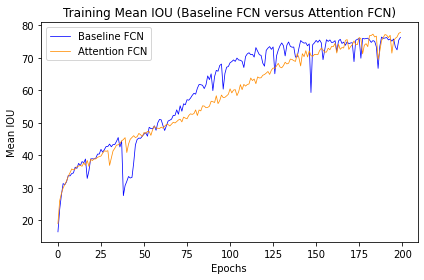

In [8]:
# Plot the first line
plt.plot(baseline, label='Baseline FCN', color='blue', linewidth = 0.75)

# Plot the second line
plt.plot(attention, label='Attention FCN', color='darkorange', linewidth = 0.75)

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Mean IOU')
plt.title('Training Mean IOU (Baseline FCN versus Attention FCN)')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [9]:
attention

array([0.1903, 0.2606, 0.2826, 0.2999, 0.3103, 0.3213, 0.336 , 0.3465,
       0.3583, 0.3557, 0.3581, 0.3653, 0.3671, 0.3693, 0.3666, 0.3772,
       0.3695, 0.3845, 0.3663, 0.388 , 0.3841, 0.3895, 0.3892, 0.3942,
       0.3963, 0.398 , 0.407 , 0.4143, 0.4127, 0.4145, 0.3692, 0.3914,
       0.414 , 0.4216, 0.4316, 0.4325, 0.4365, 0.4446, 0.4487, 0.4546,
       0.4088, 0.4346, 0.4497, 0.455 , 0.4606, 0.4548, 0.4576, 0.4676,
       0.4636, 0.4581, 0.4705, 0.4676, 0.4738, 0.4736, 0.4617, 0.4792,
       0.49  , 0.4837, 0.4837, 0.4827, 0.4869, 0.4839, 0.49  , 0.4948,
       0.4948, 0.4906, 0.4965, 0.502 , 0.4997, 0.504 , 0.509 , 0.5113,
       0.5032, 0.5178, 0.5147, 0.5126, 0.5227, 0.5279, 0.5262, 0.5286,
       0.5399, 0.5227, 0.5397, 0.5369, 0.5524, 0.5518, 0.5467, 0.5476,
       0.5512, 0.5666, 0.5651, 0.5628, 0.5835, 0.5593, 0.5688, 0.5856,
       0.5779, 0.5787, 0.5831, 0.5881, 0.6047, 0.5923, 0.6009, 0.6023,
       0.5839, 0.5958, 0.6177, 0.6023, 0.6184, 0.6132, 0.618 , 0.6198,
      

In [10]:
baseline

array([16.49779031, 23.38247503, 27.7996444 , 31.33798486, 31.00441717,
       31.9007297 , 33.82938206, 33.6808407 , 34.42049384, 34.59995862,
       36.37321931, 36.01062614, 37.55260961, 36.85941102, 38.09865897,
       37.74340483, 38.89265202, 32.9165198 , 35.26937109, 38.92663275,
       38.95972796, 38.91098246, 39.17314648, 40.40641679, 40.41353262,
       41.86060832, 40.98549663, 41.81497183, 42.75045462, 42.75379985,
       43.47709046, 42.65833754, 43.3394292 , 43.35048489, 44.29968553,
       45.49618711, 42.59323267, 44.4485388 , 27.62002954, 30.70647332,
       32.02667404, 33.51423519, 33.05606434, 33.21864266, 37.70334391,
       43.22690242, 44.89438985, 45.33382494, 45.25318257, 45.87580879,
       46.54668005, 46.97501431, 45.91424478, 48.6439647 , 48.25344607,
       48.18672157, 49.09546862, 47.72857786, 50.03284425, 51.06459183,
       50.93171028, 49.17635359, 47.66480607, 49.10906459, 50.5625648 ,
       50.83514668, 51.15217014, 52.32752566, 52.29047639, 54.01

In [2]:
test_loader = torch.load('./test_loader_CMUYamaha.pth')

In [3]:
class AttentionBlock(nn.Module):
    def __init__(self, f_g, f_l, f_int):
        super().__init__()
        
        self.w_g = nn.Sequential(
                                nn.Conv2d(f_g, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.w_x = nn.Sequential(
                                nn.Conv2d(f_l, f_int,
                                         kernel_size=1, stride=1,
                                         padding=0, bias=True),
                                nn.BatchNorm2d(f_int)
        )
        
        self.psi = nn.Sequential(
                                nn.Conv2d(f_int, 1,
                                         kernel_size=1, stride=1,
                                         padding=0,  bias=True),
                                nn.BatchNorm2d(1),
                                nn.Sigmoid(),
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)
        
        return psi*x



class SegNetAttn(nn.Module):
  def __init__(self):
    super(SegNetAttn, self).__init__()


    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 96, kernel_size = 7, stride = 2, padding = 80, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.relu1 = nn.ReLU()
    self.norm1 = nn.LocalResponseNorm(size = 5, alpha=0.0001, beta=0.75, k=1.0)
    self.pool1 = nn.MaxPool2d(kernel_size = 3, stride = 3, padding = 0, dilation = 1)
    self.nin_pool1 = nn.Conv2d(in_channels=96, out_channels=8, kernel_size=1, stride=1, padding=0, dilation=1, groups=1,  bias = True, padding_mode = 'zeros')
    self.drop_nin_pool1 = nn.Dropout(p=0.2)
    self.crop_nin_pool1 = nn.ZeroPad2d((-17, -18, -17, -18))
    self.nin_conv1 = nn.Conv2d(in_channels=96, out_channels=8, kernel_size=1, stride=1, padding=0, dilation=1, groups=1,  bias = True, padding_mode = 'zeros')
    self.crop_nin_conv1 = nn.ZeroPad2d((-53, -54, -53, -54))


    self.conv2 = nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size = 5, stride = 1, padding = 0, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1)


    self.conv3 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.relu3 = nn.ReLU()


    self.conv4 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.relu4 = nn.ReLU()


    self.conv5 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.relu5 = nn.ReLU()
    self.pool5 = nn.MaxPool2d(kernel_size = 3, stride = 3, padding = 0, dilation = 1)
    self.crop_conv5 = nn.ZeroPad2d((-8, -7, -8, -7))
    self.nin_crop_conv5 =  nn.Conv2d(in_channels = 512, out_channels = 8, kernel_size = 1, stride = 1, padding = 0, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')


    self.conv_fc6 = nn.Conv2d(in_channels = 512, out_channels = 4096, kernel_size = 6, stride = 1, padding = 2, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.relu6 = nn.ReLU()
    self.drop6 = nn.Dropout(p = 0.2)


    self.conv_fc7 = nn.Conv2d(in_channels = 4096, out_channels = 4096, kernel_size = 1, stride = 1, padding = 0, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.relu7 = nn.ReLU()
    self.drop7 = nn.Dropout(p = 0.2)
    self.nin_fc7 = nn.Conv2d(in_channels = 4096, out_channels = 8, kernel_size = 1, stride = 1, padding = 0, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.relu_nin7 = nn.ReLU()


    self.up1 = nn.ConvTranspose2d(in_channels = 8, out_channels = 8, kernel_size = 4, stride = 2, padding = 1, output_padding = 0, groups = 1, bias = True, dilation = 1)
    self.relu_up1 = nn.ReLU()
 
 
    self.up2 = nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=4, stride=2, padding=1, dilation=1, groups=1,  bias = True, padding_mode = 'zeros')
    self.relu_up2 = nn.ReLU()



    self.up3 = nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=5, stride=3, padding=1, dilation=1, groups=1,  bias = True, padding_mode = 'zeros')
    self.relu_up3 = nn.ReLU()



    self.nin6 = nn.Conv2d(in_channels = 8, out_channels = 6, kernel_size = 1, stride = 1, padding = 0, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.conv6 = nn.ConvTranspose2d(in_channels=6, out_channels=6, kernel_size= 2, stride=3, padding=60, dilation=2, groups=1,  bias = True, padding_mode = 'zeros')
    
    
    self.conv7 = nn.ConvTranspose2d(in_channels=6, out_channels=6, kernel_size=16, stride=1, padding=0, dilation=4, groups=1,  bias = True, padding_mode = 'zeros')


    self.att5 = AttentionBlock(8, 8, 8)
    self.att2 = AttentionBlock(8, 8, 8)
    self.att1 = AttentionBlock(8, 8, 8)



  def forward(self, x):
    conv1 = self.conv1(x)
    relu1 = self.relu1(conv1) # Has a skip connection
    norm1 = self.norm1(relu1)
    pool1 = self.pool1(norm1) # Has a skip connection


    conv2 = self.conv2(pool1) 
    relu2 = self.relu2(conv2)
    pool2 = self.pool2(relu2)


    conv3 = self.conv3(pool2)
    relu3 = self.relu3(conv3)


    conv4 = self.conv4(relu3)
    relu4 = self.relu4(conv4)


    conv5 = self.conv5(relu4)
    relu5 = self.relu5(conv5) # Has a skip connection
    pool5 = self.pool5(relu5)


    conv_fc6 = self.conv_fc6(pool5)
    relu6 = self.relu6(conv_fc6)
    drop6 = self.drop6(relu6)

    
    conv_fc7 = self.conv_fc7(drop6)
    relu7 = self.relu7(conv_fc7)
    drop7 = self.drop7(relu7)
    nin_fc7 = self.nin_fc7(drop7)
    relu_nin7 = self.relu_nin7(nin_fc7)


    up1 = self.up1(relu_nin7)
    relu_up1 = self.relu_up1(up1)


    crop_conv5 = self.crop_conv5(relu5)
    nin_crop_conv5 = self.nin_crop_conv5(crop_conv5)
    att5 = self.att5(g = relu_up1, x = nin_crop_conv5)


    fuse1 = torch.add(att5, relu_up1)


    up2 = self.up2(fuse1)
    relu_up2 = self.relu_up2(up2)


    nin_pool1 = self.nin_pool1(pool1)
    drop_nin_pool1 = self.drop_nin_pool1(nin_pool1)
    crop_nin_pool1 = self.crop_nin_pool1(drop_nin_pool1)
    att2 = self.att2(g = relu_up2, x = crop_nin_pool1)


    fuse2 = torch.add(att2, relu_up2)


    up3 = self.up3(fuse2)
    relu_up3 = self.relu_up3(up3)


    nin_conv1 = self.nin_conv1(conv1)
    crop_nin_conv1 = self.crop_nin_conv1(nin_conv1)
    att1 = self.att1(g = relu_up3, x = crop_nin_conv1)


    fuse3 = torch.add(att1, relu_up3)


    nin6= self.nin6(fuse3)
    conv6= self.conv6(nin6)

    
    conv7= self.conv7(conv6)
    
    return conv7

In [4]:
class SegNet(nn.Module):
  def __init__(self):
    super(SegNet, self).__init__()
    # d=0.5
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 96, kernel_size = 7, stride = 2, padding = 80, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.relu1 = nn.ReLU()
    self.norm1 = nn.LocalResponseNorm(size = 5, alpha=0.0001, beta=0.75, k=1.0)
    self.pool1 = nn.MaxPool2d(kernel_size = 3, stride = 3, padding = 0, dilation = 1)
    self.conv2 = nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size = 5, stride = 1, padding = 0, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0, dilation = 1)
    self.conv3 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.relu3 = nn.ReLU()
    self.conv4 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.relu4 = nn.ReLU()
    self.conv5 = nn.Conv2d(in_channels = 512, out_channels = 512, kernel_size = 3, stride = 1, padding = 1, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.relu5 = nn.ReLU()
    self.pool5 = nn.MaxPool2d(kernel_size = 3, stride = 3, padding = 0, dilation = 1)
    self.conv_fc6 = nn.Conv2d(in_channels = 512, out_channels = 4096, kernel_size = 6, stride = 1, padding = 2, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.relu6 = nn.ReLU()
    self.drop6 = nn.Dropout(p = 0.2)
    self.conv_fc7 = nn.Conv2d(in_channels = 4096, out_channels = 4096, kernel_size = 1, stride = 1, padding = 0, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.relu7 = nn.ReLU()
    self.drop7 = nn.Dropout(p = 0.2)
    self.nin_fc7 = nn.Conv2d(in_channels = 4096, out_channels = 8, kernel_size = 1, stride = 1, padding = 0, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.relu_nin7 = nn.ReLU()
    self.up1 = nn.ConvTranspose2d(in_channels = 8, out_channels = 8, kernel_size = 4, stride = 2, padding = 1, output_padding = 0, groups = 1, bias = True, dilation = 1)
    self.relu_up1 = nn.ReLU()
    self.crop_conv5 = nn.ZeroPad2d((-8, -7, -8, -7))
    self.nin_crop_conv5 =  nn.Conv2d(in_channels = 512, out_channels = 8, kernel_size = 1, stride = 1, padding = 0, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.up2 = nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=4, stride=2, padding=1, dilation=1, groups=1,  bias = True, padding_mode = 'zeros')
    self.relu_up2 = nn.ReLU()
    self.nin_pool1 = nn.Conv2d(in_channels=96, out_channels=8, kernel_size=1, stride=1, padding=0, dilation=1, groups=1,  bias = True, padding_mode = 'zeros')
    self.drop_nin_pool1 = nn.Dropout(p=0.2)
    self.crop_nin_pool1 = nn.ZeroPad2d((-17, -18, -17, -18))
    self.up3 = nn.ConvTranspose2d(in_channels=8, out_channels=8, kernel_size=5, stride=3, padding=1, dilation=1, groups=1,  bias = True, padding_mode = 'zeros')
    self.relu_up3 = nn.ReLU()
    self.nin_conv1 = nn.Conv2d(in_channels=96, out_channels=8, kernel_size=1, stride=1, padding=0, dilation=1, groups=1,  bias = True, padding_mode = 'zeros')
    self.crop_nin_conv1 = nn.ZeroPad2d((-53, -54, -53, -54))
    self.nin6 = nn.Conv2d(in_channels = 8, out_channels = 6, kernel_size = 1, stride = 1, padding = 0, dilation = 1, groups = 1, bias = True, padding_mode = 'zeros')
    self.conv6 = nn.ConvTranspose2d(in_channels=6, out_channels=6, kernel_size= 2, stride=3, padding=60, dilation=2, groups=1,  bias = True, padding_mode = 'zeros')
    self.conv7 = nn.ConvTranspose2d(in_channels=6, out_channels=6, kernel_size=16, stride=1, padding=0, dilation=4, groups=1,  bias = True, padding_mode = 'zeros')


  def forward(self, x):
    conv1 = self.conv1(x)
    relu1 = self.relu1(conv1) # Has a skip connection
    norm1 = self.norm1(relu1)
    pool1 = self.pool1(norm1)
    conv2 = self.conv2(pool1) # Has a skip connection
    relu2 = self.relu2(conv2)
    pool2 = self.pool2(relu2)
    conv3 = self.conv3(pool2)
    relu3 = self.relu3(conv3)
    conv4 = self.conv4(relu3)
    relu4 = self.relu4(conv4)
    conv5 = self.conv5(relu4)
    relu5 = self.relu5(conv5) # Has a skip connection
    pool5 = self.pool5(relu5)
    conv_fc6 = self.conv_fc6(pool5)
    relu6 = self.relu6(conv_fc6)
    drop6 = self.drop6(relu6)
    conv_fc7 = self.conv_fc7(drop6)
    relu7 = self.relu7(conv_fc7)
    drop7 = self.drop7(relu7)
    nin_fc7 = self.nin_fc7(drop7)
    relu_nin7 = self.relu_nin7(nin_fc7)
    up1 = self.up1(relu_nin7)
    relu_up1 = self.relu_up1(up1)
    crop_conv5 = self.crop_conv5(relu5)
    nin_crop_conv5 = self.nin_crop_conv5(crop_conv5)
    fuse1 = torch.add(nin_crop_conv5, relu_up1)
    up2 = self.up2(fuse1)
    relu_up2 = self.relu_up2(up2)
    nin_pool1 = self.nin_pool1(pool1)
    drop_nin_pool1 = self.drop_nin_pool1(nin_pool1)
    crop_nin_pool1 = self.crop_nin_pool1(drop_nin_pool1)
    fuse2 = torch.add(crop_nin_pool1, relu_up2)
    up3 = self.up3(fuse2)
    relu_up3 = self.relu_up3(up3)
    nin_conv1 = self.nin_conv1(conv1)
    crop_nin_conv1 = self.crop_nin_conv1(nin_conv1)
    fuse3 = torch.add(crop_nin_conv1, relu_up3)
    nin6= self.nin6(fuse3)
    conv6= self.conv6(nin6)
    conv7= self.conv7(conv6)
    return conv7




In [5]:
model_baseline = SegNet().to(device)
checkpoint = torch.load('./Results/FCN/Epoch Wise/FCN-CMUYamaha-200-epochs-4bs.pth')
model_baseline.load_state_dict(checkpoint)

<All keys matched successfully>

In [6]:
model_attention = SegNetAttn().to(device)
checkpoint = torch.load('./Results/3D FCN/Epoch Wise/FCNAtt-CMUYamaha-200-epochs-4bs.pth')
model_attention.load_state_dict(checkpoint)

<All keys matched successfully>

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

def createConfusionMatrix(groundtruth, prediction):

    y_pred, y_true = [],  []

    y_pred.extend(prediction.data.cpu().view(-1).tolist())
    y_true.extend(groundtruth.data.cpu().view(-1).tolist())

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    return cf_matrix

In [31]:
model_attention.eval()
IOU = {0: [], 1:[], 2:[], 3:[], 4:[], 5:[]}


with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.permute(0, 3, 1, 2)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_attention(images)
        _, predicted = torch.max(outputs.data, 1)

        classes = np.unique(predicted.data.cpu().numpy())

        df_cm = createConfusionMatrix(labels, predicted)

        intersection = np.diag(df_cm)
        ground_truth_set = df_cm.sum(axis=1)
        predicted_set = df_cm.sum(axis=0)
        union = ground_truth_set + predicted_set - intersection
        IoU = intersection / union.astype(np.float32)


        for iter, class_val in enumerate(classes):
            IOU[class_val].append(100 * IoU[iter])



        # fig, axes = plt.subplots(1, 2, figsize=(18, 4))
        # axes[0].imshow(recreateImage(predicted.cpu().numpy()[0])), axes[0].set_title('Predicted')
        # axes[1].imshow(recreateImage(labels.cpu().numpy()[0])), axes[1].set_title('Ground Truth')
        # plt.show()
        # # print('Pixel Accuracy = {} %'.format(round(correct * 100/total, 2)))


        print('IOU = ', np.mean(IoU), end = '\r')
        # IOU.append(np.mean(IoU))

        # plt.figure(figsize = (12,7))
        # sn.heatmap(df_cm, annot=True)
        # print('Loss = ',loss.item())

attention_testIOU = IOU

In [32]:
model_baseline.eval()
IOU = {0: [], 1:[], 2:[], 3:[], 4:[], 5:[]}
with torch.no_grad():
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(test_loader):
        images = images.permute(0, 3, 1, 2)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_baseline(images)
        _, predicted = torch.max(outputs.data, 1)

        classes = np.unique(predicted.data.cpu().numpy())


        df_cm = createConfusionMatrix(labels, predicted)

        intersection = np.diag(df_cm)
        ground_truth_set = df_cm.sum(axis=1)
        predicted_set = df_cm.sum(axis=0)
        union = ground_truth_set + predicted_set - intersection
        IoU = intersection / union.astype(np.float32)

        for iter, class_val in enumerate(classes):
            IOU[class_val].append(100 * IoU[iter])

        
        

        # fig, axes = plt.subplots(1, 2, figsize=(18, 4))
        # axes[0].imshow(recreateImage(predicted.cpu().numpy()[0])), axes[0].set_title('Predicted')
        # axes[1].imshow(recreateImage(labels.cpu().numpy()[0])), axes[1].set_title('Ground Truth')
        # plt.show()
        # # print('Pixel Accuracy = {} %'.format(round(correct * 100/total, 2)))


        print('IOU = ', np.mean(IoU), end = '\r')
        # IOU.append(np.mean(IoU))

        # plt.figure(figsize = (12,7))
        # sn.heatmap(df_cm, annot=True)
        # print('Loss = ',loss.item())

baseline_testIOU = IOU

In [73]:
classes = ['Sky', 'Smooth Trail', 'Rough Trail', 'High Vegetation', 'Low Vegetation', 'Obstacle']

In [74]:
base_perf, attn_perf = [], []
for i, classes_val in enumerate(classes):
    print('Class = ', classes_val)

    base = baseline_testIOU[i]
    # non_zero_data_base = base[base != 0]

    print('Baseline Performance on Test Data: ', round(np.mean(base)), '%')

    attn = attention_testIOU[i]
    # non_zero_data_attn = attn[attn != 0]

    print('Attention Performance on Test Data: ', round(np.mean(attn)), '%')




    base_perf.append(round(np.mean(base)))
    attn_perf.append(round(np.mean(attn)))


Class =  Sky
Baseline Performance on Test Data:  53 %
Attention Performance on Test Data:  55 %
Class =  Smooth Trail
Baseline Performance on Test Data:  20 %
Attention Performance on Test Data:  22 %
Class =  Rough Trail
Baseline Performance on Test Data:  22 %
Attention Performance on Test Data:  18 %
Class =  High Vegetation
Baseline Performance on Test Data:  54 %
Attention Performance on Test Data:  49 %
Class =  Low Vegetation
Baseline Performance on Test Data:  1 %
Attention Performance on Test Data:  1 %
Class =  Obstacle
Baseline Performance on Test Data:  0 %
Attention Performance on Test Data:  0 %


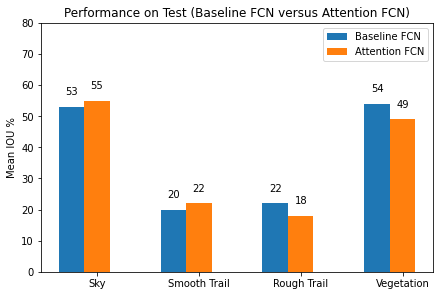

In [80]:
species = classes[:4]
species[-1] = 'Vegetation'
penguin_means = {
    'Baseline FCN': base_perf[:4],
    'Attention FCN': attn_perf[:4]}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    if attribute == 'Baseline FCN':
        color = ''
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=10)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean IOU %')
ax.set_title('Performance on Test (Baseline FCN versus Attention FCN)')
ax.set_xticks(x + width, species)
ax.legend(loc='upper right')
ax.set_ylim(0, 80)

plt.show()